# HSE 2021: Mathematical Methods for Data Analysis

## Homework 4

**Warning 1**: You have 2 weeks for this assignemnt.  **it is better to start early (!)**

**Warning 2**: it is critical to describe and explain what you are doing and why, use markdown cells


### Contents

#### Decision Trees - 7 points
* [Task 1](#task1) (0.5 points)
* [Task 2](#task2) (0.5 points)
* [Task 3](#task3) (2 points)
* [Task 4](#task4) (0.5 points)
* [Task 5](#task5) (0.5 points)
* [Task 6](#task6) (2 points)
* [Task 7](#task7) (0.5 points)
* [Task 8](#task8) (0.5 points)

#### Ensembles - 3 points
* [Task 1](#task2_1) (1 point)
* [Task 2](#task2_2) (0.7 points)
* [Task 3](#task2_3) (0.5 points)
* [Task 4](#task2_4) (0.7 points)
* [Task 5](#task2_5) (0.1 points)

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

plt.rcParams['figure.figsize'] = (11, 5)
%matplotlib inline

# Part 1. Decision Tree Regressor

In this task you will be implementing decision tree for the regression by hand. 

### Task 1 <a id="task1"></a> (0.5 points)

Here you should implement the function `H()` which calculates impurity criterion. We will be training regression tree, and will take mean absolute deviation as impurity criterion.

* You cannot use loops
* If `y` is empty, the function should return 0

In [2]:
def H(y):
    """
    Calculate impurity criterion
    
    Parameters
    ----------
    y : np.array
        array of objects target values in the node

    Returns
    -------
    H(R) : float
        Impurity in the node (measuread by variance)
    """
    if len(y) == 0: return 0;
    
    return np.mean(np.abs(y - np.mean(y)))

In [3]:
# Test the function
assert np.allclose(H(np.array([4, 2, 2, 2])), 0.75)
assert np.allclose(H(np.array([])), 0.0)

### Task 2 <a id="task2"></a>  (0.5 points)

To find the best split in the node we need to calculate the cost function. Denote: 
- `R` all the object in the node
- `j` index of the feature selected for the split
- `t` threshold
- `R_l` and `R_r` objects in the left and right child nodes correspondingly

We get the following cost function:

$$
Q(R, j, t) =\frac{|R_\ell|}{|R|}H(R_\ell) + \frac{|R_r|}{|R|}H(R_r) \to \min_{j, t},
$$

Implement the function `Q`, which should calculate value of the cost function for a given feature and threshold.

In [4]:
def Q(X, y, j, t):
    """
    Calculate cost function
    Parameters
    ----------
    X : ndarray
        array of objects in the node 
    y : ndarray
        array of target values in the node 
    j : int
        feature index (column in X)
    t : float
        threshold

    Returns
    -------
    Q : float
        Value of the cost function
    """   
    # YOUR CODE HERE
     # Разделение данных на две группы на основе порога t
    left_indices = X[:, j] <= t
    right_indices = ~left_indices
    
    y_left = y[left_indices]
    y_right = y[right_indices]

    # Вычисление импурити для каждой группы
    H_left = H(y_left)
    H_right = H(y_right)

    # Вычисление функции стоимости Q
    Q_value = (len(y_left) / len(y)) * H_left + (len(y_right) / len(y)) * H_right
    return Q_value

### Task 3 <a id="task3"></a>  (2 points)

Now, let's implement `MyDecisionTreeRegressor` class. More specifically, you need to implement the following methods:

- `best_split`
- `grow_tree`
- `get_prediction`

Also, please add `min_samples_leaf` parameter to your class

Read docstrings for more details. Do not forget to use function `Q` implemented above, when finding the `best_split`

In [5]:
class Node(object):
    """
    Class for a decision tree node.
    
    Parameters
    ----------
    right : Node() or None
        Right child
    right : Node() or None
        Left child
    threshold: float
        
    column: int
        
    depth: int
        
    prediction: float
        prediction of the target value in the node 
        (average values calculated on a train dataset)
    is_terminal:bool
        indicates whether it is a terminal node (leaf) or not
    """    
    def __init__(self, depth = None):        
        self.right = None
        self.left = None
        self.threshold = None
        self.column = None
        self.depth = depth
        self.is_terminal = False
        self.prediction = None
        
    def __repr__(self):
        if self.is_terminal:
            node_desc = 'Pred: {:.2f}'.format(self.prediction)
        else:
            node_desc = 'Col {}, t {:.2f}, Pred: {:.2f}'. \
            format(self.column, self.threshold, self.prediction)
        return node_desc

In [50]:
from sklearn.base import BaseEstimator, RegressorMixin
from sklearn.utils.validation import check_X_y, check_array, check_is_fitted


class MyDecisionTreeRegressor(RegressorMixin, BaseEstimator):
    """
    Class for a Decision Tree Regressor.

    Parameters
    ----------
    max_depth : int
        Max depth of a decision tree.
    min_samples_split : int
        Minimal number of samples (objects) in a node to make a split.
    """

    def __init__(self, max_depth=3, min_samples_split=2, min_samples_leaf=1):
        self.max_depth = max_depth
        self.min_samples_split = min_samples_split
        self.min_samples_leaf = min_samples_leaf

    def best_split(self, X, y):
        """
        Find the best split in terms of Q of data in a given decision tree node.
        Try all features and thresholds.

        Parameters
        ----------
        X : ndarray, shape (n_objects, n_features)
            Objects in the parent node
        y : ndarray, shape (n_objects, )
            1D array with the object labels.

        Returns
        -------
        best_split_column : int
            Index of the best split column
        best_threshold : float
            The best split condition.
        X_left : ndarray, shape (n_objects_l, n_features)
            Objects in the left child
        y_left : ndarray, shape (n_objects_l, )
            Objects labels in the left child.
        X_right : ndarray, shape (n_objects_r, n_features)
            Objects in the right child
        y_right : ndarray, shape (n_objects_r, )
            Objects labels in the right child.
        """
        # To store best split parameters
        best_split_column = None
        best_threshold = None
        # without splitting
        best_cost = H(y)
        for split_column in range(X.shape[1]):
            column = X[:, split_column]
            for threshold in column:
                cost = Q(X, y, split_column, threshold)
                if cost < best_cost:
                    best_cost = cost
                    best_split_column = split_column
                    best_threshold = threshold
        if best_threshold is None:
            return [None] * 6
        bools = X[:, best_split_column] <= best_threshold
        return best_split_column, best_threshold, X[bools], y[bools], X[~bools],y[~bools]

    def is_terminal(self, node, y):
        """
        Check terminality conditions based on `max_depth`,
        `min_samples_split` parameters for a given node.

        Parameters
        ----------
        node : Node,

        y : ndarray, shape (n_objects, )
            Object labels.

        Returns
        -------
        Is_termial : bool
            If True, node is terminal
        """
        if node.depth >= self.max_depth or len(y) < self.min_samples_split:
            return True
        return False

    def grow_tree(self, node, X, y):
        """
        Reccurently grow the tree from the `node` using a `X` and `y` as a dataset:
         - check terminality conditions
         - find best split if node is not terminal
         - add child nodes to the node
         - call the function recursively for the added child nodes

        Parameters
        ----------
        node : Node() object
            Current node of the decision tree.
        X : ndarray, shape (n_objects, n_features)
            Objects
        y : ndarray, shape (n_objects)
            Labels
        """
        if self.is_terminal(node, y):
            node.is_terminal = True
            node.prediction = np.mean(y)
            return

        best_split_column, best_threshold, X_left, y_left, X_right, y_right = self.best_split(X, y)

        if best_threshold is None:
            node.is_terminal = True
            node.prediction = np.mean(y)
            return
        
        node.column = best_split_column
        node.threshold = best_threshold
        
        node.left = Node(node.depth + 1)
        node.right = Node(node.depth + 1)
        
        self.grow_tree(node.left, X_left, y_left)
        self.grow_tree(node.right, X_right, y_right)

    def fit(self, X, y):
        """
        Fit the Decision Tree Regressor.

        Parameters
        ----------
        X : ndarray, shape (n_samples, n_features)
            The input samples.
        y : ndarray, shape (n_samples,) or (n_samples, n_outputs)
            The target values.
        Returns
        -------
        self : object
            Returns self.
        """
        X, y = check_X_y(X, y, accept_sparse=False)
        self.is_fitted_ = True
        self.n_features_in_ = X.shape[1]

        # Initialize the tree (root node)
        self.tree_ = Node()
        self.tree_.depth = 1

        # Grow the tree
        self.grow_tree(self.tree_, X, y)
        return self

    def get_prediction(self, node, x):

        """
        Get prediction for an object `x`
            - Return prediction of the `node` if it is terminal
            - Otherwise, recursively call the function to get
            predictions of the proper child

        Parameters
        ----------
        node : Node() object
            Current node of the decision tree.
        x : ndarray, shape (n_features,)
            Array of feature values of one object.
        Returns
        -------
        y_pred : float
            Prediction for an object x
        """
        # YOUR CODE HERE
        if node.is_terminal:
            return node.prediction
        
        if x[node.column] < node.threshold:
            return self.get_prediction(node.left, x)
        return self.get_prediction(node.right, x)

    def predict(self, X):
        """
        Get prediction for each object in X

        Parameters
        ----------
        X : ndarray, shape (n_samples, n_features)
            The input samples.
        Returns
        -------
        y : ndarray, shape (n_samples,)
            Returns predictions.
        """
        # Check input and that `fit` had been called
        X = check_array(X, accept_sparse=False)
        check_is_fitted(self, 'is_fitted_')
        # Get predictions
        y_predicted = []
        for x in X:
            y_curr = self.get_prediction(self.tree_, x)
            y_predicted.append(y_curr)
        return np.array(y_predicted)

In [51]:
# check yourself
from sklearn.utils.estimator_checks import check_estimator
check_estimator(MyDecisionTreeRegressor())

### Task 4 <a id="task4"></a>  (0.5 points)

Load boston dataset and split it on the train ($75\%$) and test ($25\%$). Fit Decision Tree of **depth 1, 3, 5** and make the following plots for every case:

- Scatter plot of the traning points (selected for split feature on the x-axis, target variable on the y-axis)
- Fitted model (tree visualization)

Compare `MAE` on train and test. Have trees overfitted?

In [131]:
data = pd.read_csv('boston.txt', delimiter='\s+')

data['B'][::2] = data['CRIM'][1::2]
data['LSTAT'][::2] = data['ZN'][1::2]
data['MEDV'][::2] = data['INDUS'][1::2]
data = data[::2]
X, y = np.array(data.drop(columns='MEDV').values), np.array(data['MEDV'])

In [134]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error

depths = [1, 3, 5]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, shuffle=True, random_state=42)

def DFS_tree(node, cols, thres):
    if node.is_terminal:
        return
    col = node.column
    cols.add(col)
    if col in thres:
        thres[col].append(node.threshold)
    else:
        thres[col] = [node.threshold]
    DFS_tree(node.left, cols, thres)
    DFS_tree(node.right, cols, thres)
    return

des_trees = [MyDecisionTreeRegressor(max_depth=i).fit(X_train, y_train) for i in depths]
tr_cols = []
tr_threshold = []
for d, tree in zip(depths, des_trees):
    cols = set()
    thresholds = {}
    DFS_tree(tree.tree_, cols, thresholds)
    print('MAE depth =', d,  '| train: ', mean_absolute_error(y_train, tree.predict(X_train)),', test: ', mean_absolute_error(y_test, tree.predict(X_test)), ', cols = ', list(cols))
    tr_cols.append(list(cols))
    tr_threshold.append(thresholds)

MAE depth = 1 | train:  6.889290662136855 , test:  6.222778551097999 , cols =  []
MAE depth = 3 | train:  3.61571195711354 , test:  3.533031771028621 , cols =  [12, 5]
MAE depth = 5 | train:  2.717075280734322 , test:  3.0454072222074795 , cols =  [0, 5, 6, 7, 9, 12]


Слишком глубокие деревья, очевидно, переобучаются. Но тут значение mae падает и на тесте, и на трейне, так что пока не стоит при таких глубинах говорить о переобучении

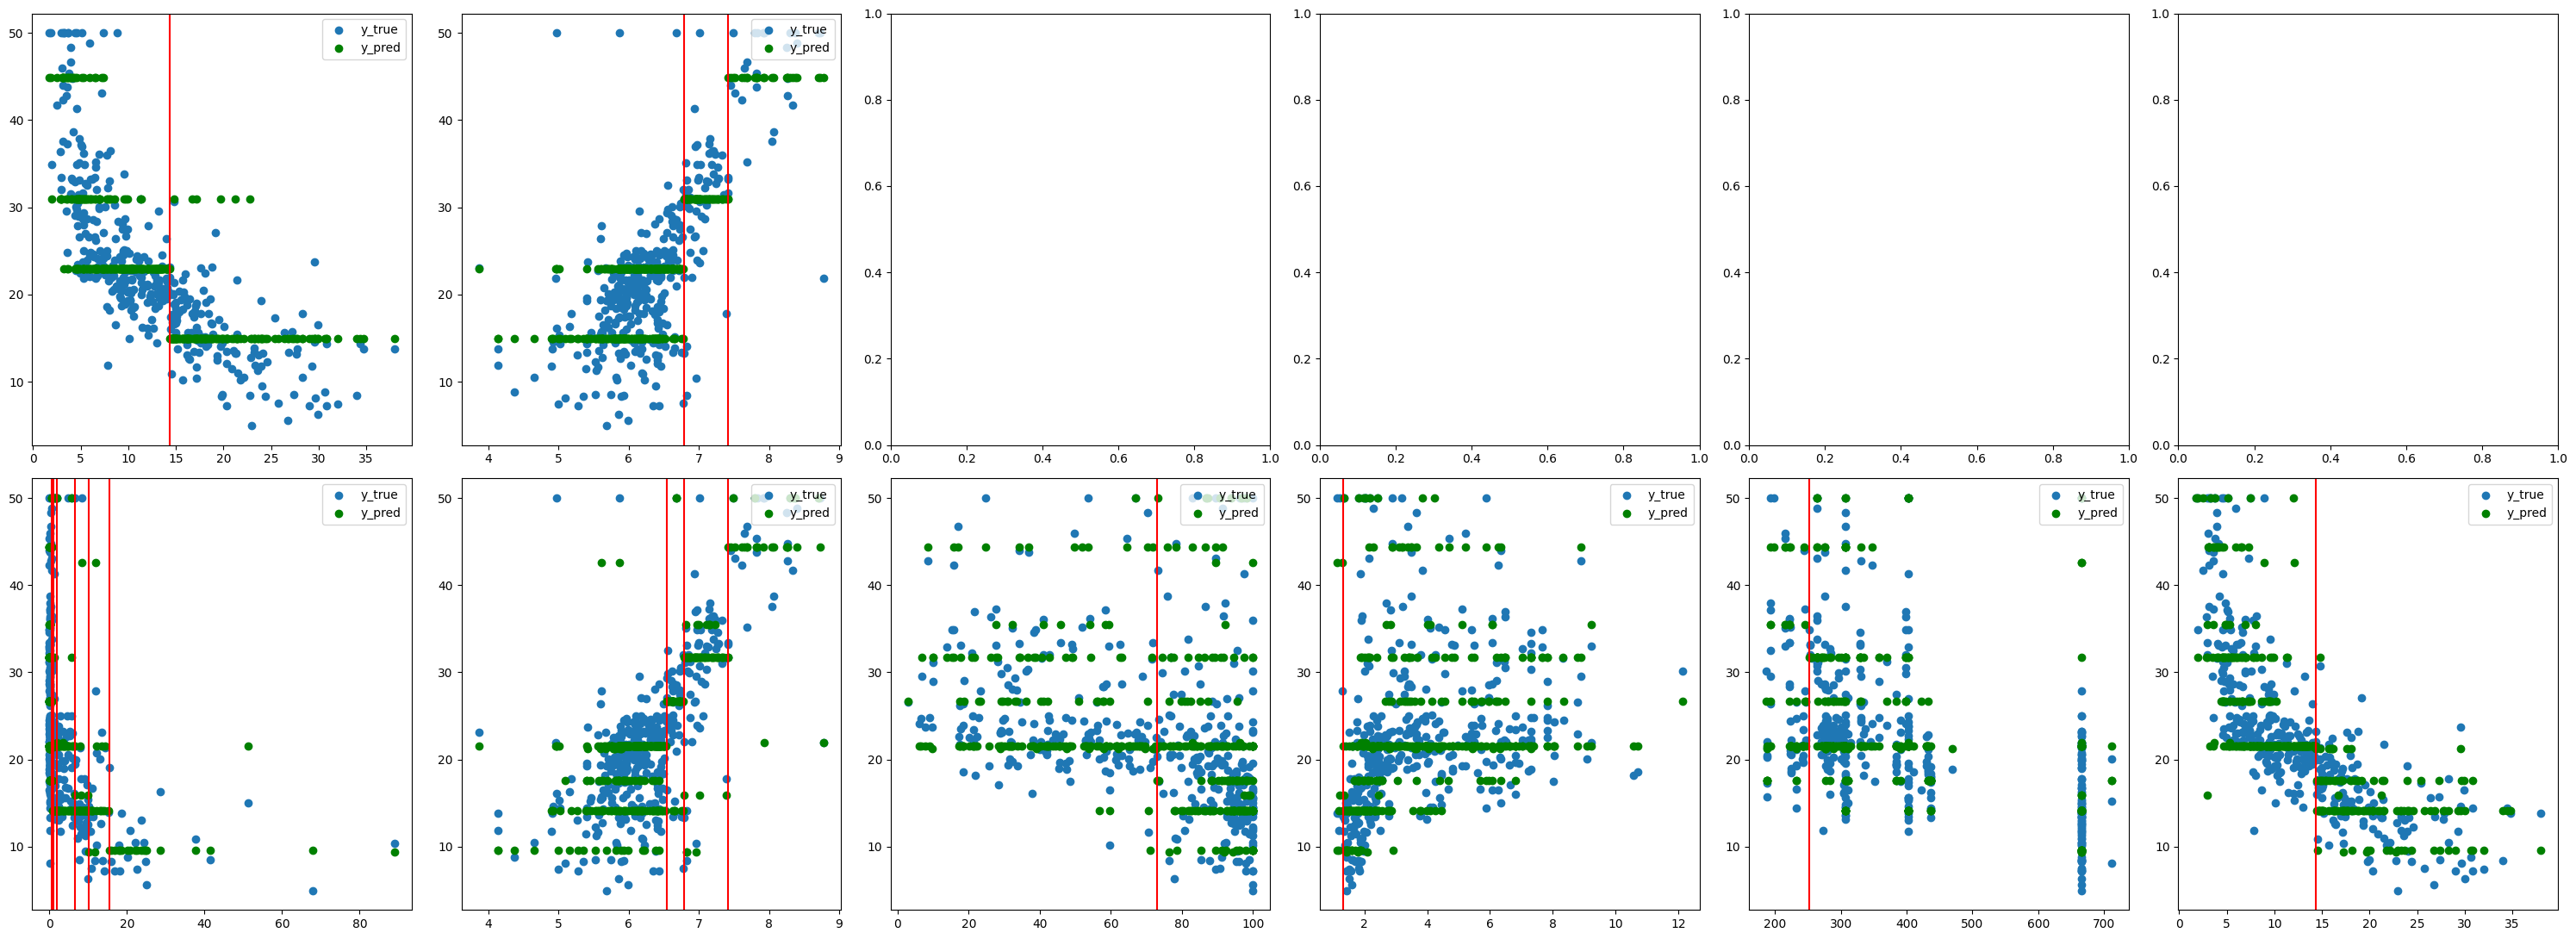

In [137]:
ncols, nrows = len(max(tr_cols, key=lambda x: len(x))),  len(depths)
fig, axs = plt.subplots(ncols= ncols, nrows = nrows - 1, figsize=(30, 11))

for i, (tree, tr_thr) in enumerate(zip(des_trees[1:], tr_threshold[1:]), 1):
    for j, tr_col in enumerate(tr_cols[i]):
        axs[i - 1][j].scatter(X_train[:, tr_col], y_train, label = 'y_true')
        idx = np.argsort(X_train[:, tr_col])
        axs[i - 1][j].scatter(X_train[:, tr_col][idx], tree.predict(X_train[idx]), color = 'g', label = 'y_pred')
        for th in tr_thr[tr_col]:
            axs[i - 1][j].axvline(x = th, color = 'r')
        axs[i - 1][j].legend(loc='upper right')
plt.tight_layout()
plt.show()

### Task 5 <a id="task5"></a>  (0.5 points)

Keep working with boston dataset. 
- Use `GridSearchCV` to find the best hyperparameters among [`max_depth`, `min_samples_leaf`] on 5-Fold cross-validation
- Train the model with the best set of hyperparameters on the whole train dataset. 
- Report `MAE` on test dataset and hyperparameters of the best estimator. 

In [139]:
from sklearn.model_selection import KFold
from sklearn.model_selection import GridSearchCV

cv = KFold(n_splits=5)
params_grid = [{'max_depth': np.arange(1, 20, 2), 'min_samples_leaf': np.arange(1, 5)}]
svc_grid_search = GridSearchCV(MyDecisionTreeRegressor(), params_grid, verbose=4, cv=cv, scoring='neg_mean_absolute_error').fit(X_train, y_train)

Fitting 5 folds for each of 40 candidates, totalling 200 fits
[CV 1/5] END ..max_depth=1, min_samples_leaf=1;, score=-7.074 total time=   0.0s
[CV 2/5] END ..max_depth=1, min_samples_leaf=1;, score=-7.034 total time=   0.0s
[CV 3/5] END ..max_depth=1, min_samples_leaf=1;, score=-7.354 total time=   0.0s
[CV 4/5] END ..max_depth=1, min_samples_leaf=1;, score=-7.037 total time=   0.0s
[CV 5/5] END ..max_depth=1, min_samples_leaf=1;, score=-6.091 total time=   0.0s
[CV 1/5] END ..max_depth=1, min_samples_leaf=2;, score=-7.074 total time=   0.0s
[CV 2/5] END ..max_depth=1, min_samples_leaf=2;, score=-7.034 total time=   0.0s
[CV 3/5] END ..max_depth=1, min_samples_leaf=2;, score=-7.354 total time=   0.0s
[CV 4/5] END ..max_depth=1, min_samples_leaf=2;, score=-7.037 total time=   0.0s
[CV 5/5] END ..max_depth=1, min_samples_leaf=2;, score=-6.091 total time=   0.0s
[CV 1/5] END ..max_depth=1, min_samples_leaf=3;, score=-7.074 total time=   0.0s
[CV 2/5] END ..max_depth=1, min_samples_leaf=3;

### Task 6 <a id="task6"></a>  (2 points)

Recall definition of bias and variance:
$$
\text{Bias}^2 = \mathbb{E}_{p(x, y)} \left[  (f(x) - \mathbb{E}_{\mathbb{X}}a_{\mathbb{X}}(x))^2 \right] \\
\text{Variance} = \mathbb{E}_{p(x, y)} \left[  \mathbb{V}_{\mathbb{X}}( a_{\mathbb{X}}(x))  \right]
$$

We wil now use the following algorithm to estimate bias and variance:

1. Use bootsrap to create `n_iter` samples from the original dataset: $X_1, \dots, X_{n_iter}$
2. For each bootstrapped sample define out-of-bag (OOB) sample $Z_1, \dots, Z_{n_iter}$, which contain all the observations, which did not appear in the corresponding boostraped sample
3. Fit the model on $X_i$s and compute predictions on $Z_i$s
4. For a given *object* $n$:
     - bias^2: squared difference between true value $y_n$ and average prediction (average over the algorithms, for which $n$ was in OOB)
     - variance: variance of the prediction (predictions of the algorithms, for which $n$ was in OOB)
5. Average bias^2 and variance over all the points
    
**Implement `get_bias_variance` function, using the algorithm above**

*Note:*  You can only use 1 loop (for bootsrap iterations). All other operations should be vectorized. 

In [248]:
from sklearn.base import clone

def get_bias_variance(estimator, x, y, n_iter):
    """
    Calculate bias and variance of the `estimator`.
    Using a given dataset and bootstrap with `n_iter` samples.

    Parameters
    ----------
    x : ndarray, shape (n_samples, n_features)
        The input samples.
    y : ndarray, shape (n_samples,)
        The target values.
    n_iter: int
        Number of bootstrap samples.

    Returns
    -------
    bias2 : float,
        Estimated squared bias.
    variance : float,
        Estimated variance.
    """
    estimators = [clone(estimator) for i in range(n_iter)]
    y_preds = np.full((n_iter, len(y)), min(y) - 1.)
    for i in range(n_iter):
        idx = np.random.choice(len(y), len(y), replace=True)

        mask = np.zeros(y.shape,dtype=bool)
        mask[idx] = True

        est = estimators[i]
        est.fit(x[idx], y[idx])
        y_preds[i][~mask] = est.predict(x[~mask])

    oob_mask = (y_preds > (min(y) - 0.5))
    count_oob = oob_mask.sum(axis = 0).reshape(1, -1) + 1e-15
    y_preds = y_preds * oob_mask
    mean_preds = (y_preds/count_oob).sum(axis = 0)
    
    bias2 = np.mean((mean_preds - y) ** 2)
    variance = np.mean((oob_mask * (mean_preds.reshape(1, -1) - y_preds) ** 2/count_oob).sum(axis=0))

    return bias2, variance

In [249]:
# Test
estimator = MyDecisionTreeRegressor(max_depth=8, min_samples_split=15)

get_bias_variance(estimator, X_train, y_train, 10)

(30.535575699485896, 12.59638208349442)

In [250]:
from mlxtend.evaluate import bias_variance_decomp
avg_expected_loss, avg_bias, avg_var = bias_variance_decomp(
        tree, X_train, y_train, X_test, y_test, 
        loss='mse',
        random_seed=123, num_rounds=10)

print('Average expected loss: %.3f' % avg_expected_loss)
print('Average bias: %.3f' % avg_bias)
print('Average variance: %.3f' % avg_var)

Average expected loss: 22.231
Average bias: 13.891
Average variance: 8.339


### Task 7 <a id="task7"></a>  (0.5 points)

Compute bias and variance for the trees with different min_samples_split. Plot how bias and variance change as min_samples_split increases. 

Comment on what you observe, how does your result correspond to theory?

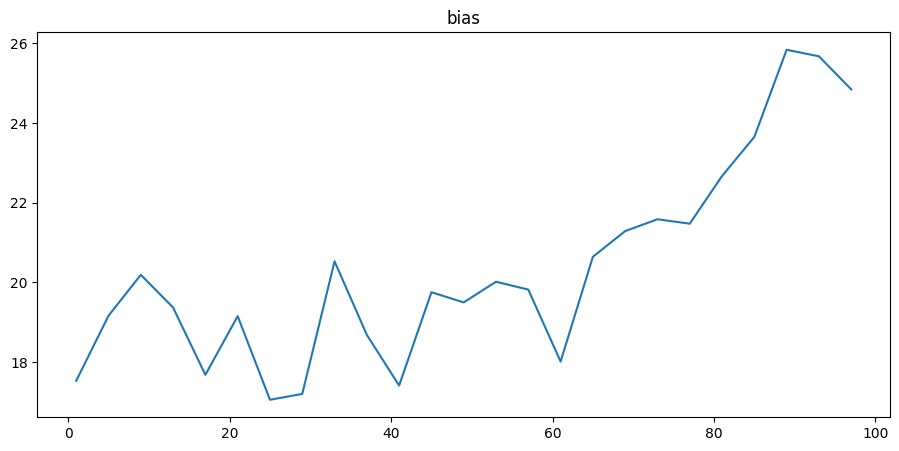

In [246]:
min_samples_split = np.arange(1, 100, 4)
results = []
for sample in min_samples_split:
    estimator = MyDecisionTreeRegressor(max_depth=10, min_samples_split=sample)
    bias, var = get_bias_variance(estimator, X_train, y_train, 30)
    results.append([bias, var])
res = np.array(results)
plt.plot(min_samples_split, res[:, 0])
plt.title('bias')
plt.show()

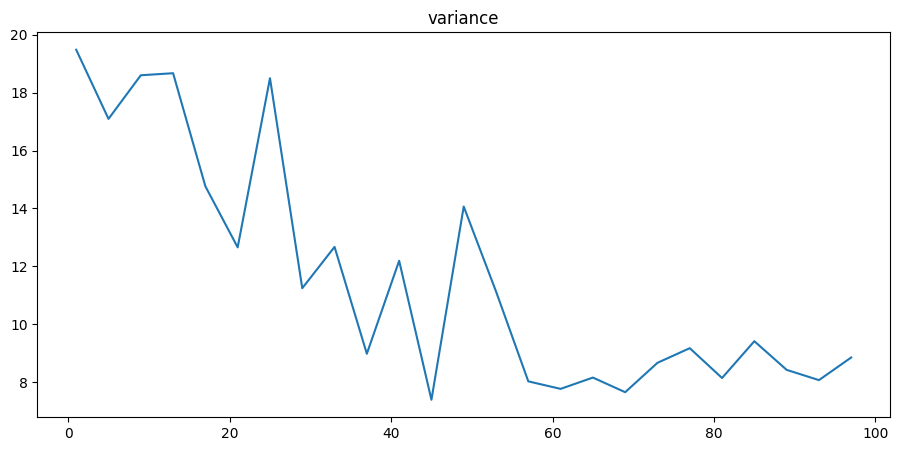

In [247]:
plt.plot(min_samples_split, res[:, 1])
plt.title('variance')
plt.show()

Низкий bias и высокий разброс - следствие переобучения. При слишком малом числе мин количества объектов в листе на обучающей выборке мы получаем переобучение - низкий bias и высокую variane, при увеличении числа мин объектов у нас уменьшаются реурсы для того, чтоб модель переобучилась на трейне (тк листья быстро теряют способность делиться для оверфита трейна), поэтому разброс падает, по в то же время растет сдвиг. Так что это полностью согласуется с теорией

### Task 8 <a id="task8"></a>  (0.5 points)

Let's try to reduce variance with bagging. Use `sklearn.ensemble.BaggingRegressor` to get an ensemble and compute its bias and variance. 

Answer the following questions:
 - How bagging should affect bias and variance in theory?
 - How bias and variance change (if they change) compared to an individual tree in you experiments? 
 - Do your results align with the theory? Why?

In [253]:
from sklearn.ensemble import BaggingRegressor

estimator = MyDecisionTreeRegressor(max_depth=10, min_samples_split=15)
print('individual tree', get_bias_variance(estimator, X_train, y_train, 10))
regr = BaggingRegressor(estimator=estimator, n_estimators=5, random_state=42)
print('bagging', get_bias_variance(regr, X_train, y_train, 10))

individual tree (33.81065700275864, 12.796898192230888)
bagging (19.904241660940613, 4.993615280416965)


Если между моделями отсутствует корреляция и модели можно считать независимыми - из этого следует, что если брать их ансамбль в виде бэггинга, то сдвиг в теории меняться не должен (а у каждого решающего дерева часто все хорошо со сдвигом, что не скажешь про разброс), в то же время дисперсия уменьшается в n раз (свойство дисперсии среднего n независимых случ величин). По этому от бэггинга мы получаем теоретически такой же bias, но при этом можем в n раз уменьшить variance. Результаты для разброса согласуются с теорией, в то время как мы имеем также значительное уменьшение сдвига. В целом у нас может наблюдаться корреляци между моделями, из-за ограниченной обучающей выборки для бустрапа, поэтому мы можем иметь эффект, когда сдвиг для совокупности в среднем уменьшается, в то время как variance уменьшается, но меньше, чем в n раз, как раз из-за некоторой скоррелированности. В случайном лесе для меньшей скореллированности еще используют RMS, плюс нужно взять очень глубокие и переобученные деревья для беггинга, чтобы иметь низкую скореллированность и низкий сдвиг, а разброс можно уменьше большим числом деревьев

# Part 2. More Ensembles

In this part we will be working with [Billionaires Statistics Dataset](https://www.kaggle.com/datasets/nelgiriyewithana/billionaires-statistics-dataset) to solve a classification task. 

### Task 1 <a id="task2_1"></a> (1 point)

Let's start with data preprocessing. 

0. Drop columns, which are not usefull (e.g. a lot of missing values). Motivate your choice. 
1. Split dataset into train and test
2. You've probably noticed that we have both categorical and numerical columns. Here is what you need to do with them:
    - Categorical: Fill missing values and apply one-hot-encoding (if there are many unique values in a column, you can group them by meaning)
    - Numeric: Fill missing values
    
Use `ColumnTranformer` to define a single transformer for all the columns in the dataset. It takes as input a list of tuples

```
ColumnTransformer([
    ('name1', transform1, column_names1),
    ('name2', transform2, column_names2)
])
```

Pay attention to an argument `remainder='passthrough'`. [Here](https://scikit-learn.org/stable/modules/compose.html#column-transformer) you can find some examples of how to use column transformer. 
    
Since we want to apply 2 transformations to categorical feature, it is very convenient to combine them into a `Pipeline`:

```
double_tranform = make_pipeline(
                        transform_1,
                        transform_2
                        )
```

P.S. Choose your favourite way to fill missing values. 

*Hint* Categorical column usually have `dtype = 'object'`. This may help to obtain list of categorical and numerical columns on the dataset. 

In [19]:
from sklearn.preprocessing import LabelEncoder
import pandas as pd
import numpy as np

df = pd.read_csv('Billionaires Statistics Dataset.csv')

le = LabelEncoder()
y = le.fit_transform(df['selfMade'])
X = df.drop('selfMade', axis=1)
X.head(5)

,rank,finalWorth,category,personName,age,country,city,source,industries,countryOfCitizenship,...,cpi_change_country,gdp_country,gross_tertiary_education_enrollment,gross_primary_education_enrollment_country,life_expectancy_country,tax_revenue_country_country,total_tax_rate_country,population_country,latitude_country,longitude_country
0,1,211000,Fashion & Retail,Bernard Arnault & family,74.0,France,Paris,LVMH,Fashion & Retail,France,...,1.1,"$2,715,518,274,227",65.6,102.5,82.5,24.2,60.7,67059887.0,46.227638,2.213749
1,2,180000,Automotive,Elon Musk,51.0,United States,Austin,"Tesla, SpaceX",Automotive,United States,...,7.5,"$21,427,700,000,000",88.2,101.8,78.5,9.6,36.6,328239523.0,37.090240,-95.712891
2,3,114000,Technology,Jeff Bezos,59.0,United States,Medina,Amazon,Technology,United States,...,7.5,"$21,427,700,000,000",88.2,101.8,78.5,9.6,36.6,328239523.0,37.090240,-95.712891
3,4,107000,Technology,Larry Ellison,78.0,United States,Lanai,Oracle,Technology,United States,...,7.5,"$21,427,700,000,000",88.2,101.8,78.5,9.6,36.6,328239523.0,37.090240,-95.712891
4,5,106000,Finance & Investments,Warren Buffett,92.0,United States,Omaha,Berkshire Hathaway,Finance & Investments,United States,...,7.5,"$21,427,700,000,000",88.2,101.8,78.5,9.6,36.6,328239523.0,37.090240,-95.712891


Выброшенные колонки:

organization - много пропусков, и при one-hot будет слишком большой sparse

country - у нас есть численные показатели, индивидуальные для каждой страны

personName, lastName firstName - зачем

rank - как индекс

category - эквивалентно industries

countryOfCitizenship - почти всегда совпадает с country

title - много пропусков мало смысла

birthDate, birthYear', 'birthMonth' - есть age

date - у всех одна

'state', 'residenceStateRegion' - непонятно зачем + пропуски

'source' - будет слишком большой sparse, лучше оставить только industries



In [20]:
nan_col = []
for col in X.columns:
    nan_rate = len(X[X[col].isna()])/len(X)
    if nan_rate > 0:
        nan_col.append((col, nan_rate))
for col_rate in nan_col:
    print(col_rate)

('age', 0.02462121212121212)
('country', 0.014393939393939395)
('city', 0.02727272727272727)
('organization', 0.8768939393939394)
('birthDate', 0.02878787878787879)
('firstName', 0.0011363636363636363)
('title', 0.8715909090909091)
('state', 0.7147727272727272)
('residenceStateRegion', 0.7170454545454545)
('birthYear', 0.02878787878787879)
('birthMonth', 0.02878787878787879)
('birthDay', 0.02878787878787879)
('cpi_country', 0.0696969696969697)
('cpi_change_country', 0.0696969696969697)
('gdp_country', 0.06212121212121212)
('gross_tertiary_education_enrollment', 0.06893939393939394)
('gross_primary_education_enrollment_country', 0.06856060606060606)
('life_expectancy_country', 0.06893939393939394)
('tax_revenue_country_country', 0.06931818181818182)
('total_tax_rate_country', 0.06893939393939394)
('population_country', 0.06212121212121212)
('latitude_country', 0.06212121212121212)
('longitude_country', 0.06212121212121212)


In [21]:
drop_cols = ['country', 'rank', 'city', 'personName', 'organization', 'category', 'countryOfCitizenship', 'title', 'birthDate', 
             'lastName', 'firstName', 'date', 'birthDay', 'birthYear', 'birthMonth', 'state', 'residenceStateRegion', 'source']
X_ = X.drop(columns=drop_cols)

X_['gdp_country'] = X_['gdp_country'].apply(lambda x: int(x.replace(',', '')[1:]) if x == x else x)

Заменим все пропуски на медиану по столбцу, как видим пропуски касаются информации о стране и еще немного пропусков в возрасте, если признак не численный, то заменим на моду

In [22]:
nan_col_medians = []
for col in X_.columns:
    nan_rate = len(X_[X_[col].isna()])/len(X_)
    if nan_rate > 0:
        if X[col].dtype == object:
            nan_col_medians.append((col, X_[~X_[col].isna()][col].mode()))
        else:
            nan_col_medians.append((col, X_[~X_[col].isna()][col].median()))
for col, median in nan_col_medians:
    if type(median) == type(X_[col]):
        median = median.iloc[0]
    X_[col] = X_[col].apply(lambda x: median if x != x else x)
    print(median)

65.0
117.24
2.9
21427700000000.0
65.6
101.8
78.5
9.6
41.2
328239523.0
37.09024
10.451526


In [23]:
for col in X_.columns:
    print(col, len(X_[X_[col].isna()])/len(X_))

finalWorth 0.0
age 0.0
industries 0.0
status 0.0
gender 0.0
cpi_country 0.0
cpi_change_country 0.0
gdp_country 0.0
gross_tertiary_education_enrollment 0.0
gross_primary_education_enrollment_country 0.0
life_expectancy_country 0.0
tax_revenue_country_country 0.0
total_tax_rate_country 0.0
population_country 0.0
latitude_country 0.0
longitude_country 0.0


In [25]:
X_.head(10)

,finalWorth,age,industries,status,gender,cpi_country,cpi_change_country,gdp_country,gross_tertiary_education_enrollment,gross_primary_education_enrollment_country,life_expectancy_country,tax_revenue_country_country,total_tax_rate_country,population_country,latitude_country,longitude_country
0,211000,74.0,Fashion & Retail,U,M,110.05,1.1,2.715518e+12,65.6,102.5,82.5,24.2,60.7,6.705989e+07,46.227638,2.213749
1,180000,51.0,Automotive,D,M,117.24,7.5,2.142770e+13,88.2,101.8,78.5,9.6,36.6,3.282395e+08,37.090240,-95.712891
2,114000,59.0,Technology,D,M,117.24,7.5,2.142770e+13,88.2,101.8,78.5,9.6,36.6,3.282395e+08,37.090240,-95.712891
3,107000,78.0,Technology,U,M,117.24,7.5,2.142770e+13,88.2,101.8,78.5,9.6,36.6,3.282395e+08,37.090240,-95.712891
4,106000,92.0,Finance & Investments,D,M,117.24,7.5,2.142770e+13,88.2,101.8,78.5,9.6,36.6,3.282395e+08,37.090240,-95.712891
5,104000,67.0,Technology,D,M,117.24,7.5,2.142770e+13,88.2,101.8,78.5,9.6,36.6,3.282395e+08,37.090240,-95.712891
6,94500,81.0,Media & Entertainment,U,M,117.24,7.5,2.142770e+13,88.2,101.8,78.5,9.6,36.6,3.282395e+08,37.090240,-95.712891
7,93000,83.0,Telecom,U,M,141.54,3.6,1.258287e+12,40.2,105.8,75.0,13.1,55.1,1.260140e+08,23.634501,-102.552784
8,83400,65.0,Diversified,D,M,180.44,7.7,2.611000e+12,28.1,113.0,69.4,11.2,49.7,1.366418e+09,20.593684,78.962880
9,80700,67.0,Technology,D,M,117.24,7.5,2.142770e+13,88.2,101.8,78.5,9.6,36.6,3.282395e+08,37.090240,-95.712891


In [41]:
from sklearn.pipeline import make_pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.impute import SimpleImputer

categorial_cols = [col for col in X_.columns if X_[col].dtype == object]
sum = 0
for cat in categorial_cols:
    sum += X_[cat].nunique() - 1
    print(X_[cat].nunique() - 1)
print(categorial_cols, ', categorical columns with drop first: ', sum)

17
5
1
['industries', 'status', 'gender'] , categorical columns with drop first:  23


In [36]:
X__ = OneHotEncoder(drop='first', sparse_output = False).fit_transform(X_[categorial_cols])
X = np.hstack([X_.drop(columns=categorial_cols).values, X__])

X__.shape, X.shape, len(X_.columns) - len(categorial_cols) + X__.shape[1]

((2640, 23), (2640, 36), 36)

### Task 2 <a id="task2_2"></a> (0.7 points)

Fit and compare 5 different models (use sklearn): Gradient Boosting, Random Forest, Decision Tree, SVM, Logitics Regression
    
* Choose one classification metric and justify your choice .
* Compare the models using score on cross validation. Mind the class balance when choosing the cross validation. (You can read more about different CV strategies [here](https://scikit-learn.org/stable/modules/cross_validation.html#stratified-k-fold))
* Which model has the best performance? Which models overfit or underfit?

Для выбора метрики проверим баланс классов

In [44]:
'0: ', (y == 0).sum(), ', 1: ', (y == 1).sum(), ', proportion: ', (y == 1).sum()/(len(y))

('0: ', 828, ', 1: ', 1812, ', proportion: ', 0.6863636363636364)

Есть дисбаланс классов, accuracy и precision подходят не очень (берем классификатор, предсказывающий только 1, получаем бесплатно acc = prec ~ 0.7 и recall = 1.0). Поэтому удобно взять F1 скор, чтоб учесть и precision и recall

In [62]:
from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score


gb_model = GradientBoostingClassifier()
rf_model = RandomForestClassifier()
dt_model = DecisionTreeClassifier()
svm_model = SVC()
lr_model = LogisticRegression()

models = [gb_model, rf_model, dt_model, svm_model, lr_model]

for model in models:
    scores = cross_val_score(model, X, y, cv=5, scoring='f1') 
    print(model.__class__.__name__, "| f1: ", scores.mean())

GradientBoostingClassifier | f1:  0.6629688203480435
RandomForestClassifier | f1:  0.783066292220311
DecisionTreeClassifier | f1:  0.6488273604003438
SVC | f1:  0.8140158135663753
LogisticRegression | f1:  0.8140158135663753


### Task 3 <a id="task2_3"></a> (0.5 points)

More Gradient Boosting. You will have to take one of the three popular boosting implementations (xgboost, lightgbm, catboost). Select hyperparameters (number of trees, learning rate, depth) on cross-validation and compare with the methods from the previous task. 

In [48]:
from catboost import CatBoostClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

param_grid = {
    'iterations': [100, 200, 300],  
    'learning_rate': [0.01, 0.05, 0.1], 
    'depth': [6, 8, 10]  
}

catboost_model = CatBoostClassifier()

grid_search = GridSearchCV(estimator=catboost_model, param_grid=param_grid, scoring='f1', cv=3)

grid_search.fit(X_train, y_train)

best_params = grid_search.best_params_
print("Best param:", best_params)

best_model = grid_search.best_estimator_

y_pred = best_model.predict(X_test)

f1_ = f1_score(y_test, y_pred)
print("f1 test:", f1_)

0:	learn: 0.6874104	total: 180ms	remaining: 17.8s
1:	learn: 0.6815624	total: 194ms	remaining: 9.51s
2:	learn: 0.6758368	total: 201ms	remaining: 6.48s
3:	learn: 0.6696323	total: 208ms	remaining: 4.99s
4:	learn: 0.6642929	total: 211ms	remaining: 4.02s
5:	learn: 0.6581454	total: 215ms	remaining: 3.36s
6:	learn: 0.6533056	total: 220ms	remaining: 2.92s
7:	learn: 0.6488543	total: 223ms	remaining: 2.56s
8:	learn: 0.6440984	total: 226ms	remaining: 2.28s
9:	learn: 0.6397549	total: 228ms	remaining: 2.05s
10:	learn: 0.6378381	total: 230ms	remaining: 1.86s
11:	learn: 0.6333742	total: 233ms	remaining: 1.71s
12:	learn: 0.6293346	total: 235ms	remaining: 1.57s
13:	learn: 0.6256595	total: 236ms	remaining: 1.45s
14:	learn: 0.6217347	total: 238ms	remaining: 1.35s
15:	learn: 0.6176004	total: 240ms	remaining: 1.26s
16:	learn: 0.6138499	total: 242ms	remaining: 1.18s
17:	learn: 0.6105704	total: 244ms	remaining: 1.11s
18:	learn: 0.6068139	total: 247ms	remaining: 1.05s
19:	learn: 0.6031117	total: 250ms	remaini

### Task 4 <a id="task2_4"></a> (0.7 points)

Now let's train more fancy ensembles:

* Bagging with decision trees as base estimators
* Bagging with gradient boosting (with large amount of trees, >100) as base estimators
* [Voting classifier](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.VotingClassifier.html#sklearn.ensemble.VotingClassifier) 
* [Stacking Classifier](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.StackingClassifier.html#sklearn.ensemble.StackingClassifier) with Logistic Regression as a final model
* [Stacking Classifier](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.StackingClassifier.html#sklearn.ensemble.StackingClassifier) with Gradeint Boosting as a final model


If not stated in the task, feel free to tune / choose hyperparameters and base models.

Answer the questions:
* Which model has the best performance?
* Does bagging reduce overfiting of the gradient boosting with large amount of trees? 
* What is the difference between voting and staking? 

In [60]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import BaggingClassifier, GradientBoostingClassifier, RandomForestClassifier, VotingClassifier, StackingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import f1_score

#Bagging
bagging_dt = BaggingClassifier(estimator=DecisionTreeClassifier(), n_estimators=50, random_state=42).fit(X_train, y_train)
y_pred_bagging_dt = bagging_dt.predict(X_test)
print("Bagging with decision trees f1: ", f1_score(y_test, y_pred_bagging_dt))

bagging_gb = BaggingClassifier(estimator=GradientBoostingClassifier(n_estimators=150), n_estimators=10, random_state=42).fit(X_train, y_train)
y_pred_bagging_gb = bagging_gb.predict(X_test)
print("Bagging with gradient boosting f1: ", f1_score(y_test, y_pred_bagging_gb))

# Voting 
dt_classifier = DecisionTreeClassifier(random_state=42)
rf_classifier = RandomForestClassifier(n_estimators=50, random_state=42)
gb_classifier = GradientBoostingClassifier(n_estimators=100, random_state=42)

voting_classifier = VotingClassifier(estimators=[('dt', dt_classifier), ('rf', rf_classifier), ('gb', gb_classifier)], voting='hard').fit(X_train, y_train)
y_pred_voting = voting_classifier.predict(X_test)
print("Voting classifier f1: ", f1_score(y_test, y_pred_voting))

#Stacking
stacking_lr = StackingClassifier(estimators=[('dt', dt_classifier), ('rf', rf_classifier), ('gb', gb_classifier)],
                                  final_estimator=LogisticRegression()).fit(X_train, y_train)
y_pred_stacking_lr = stacking_lr.predict(X_test)
print("Stacking with logistic regression f1: ", f1_score(y_test, y_pred_stacking_lr))

stacking_gb = StackingClassifier(estimators=[('dt', dt_classifier), ('rf', rf_classifier), ('gb', gb_classifier)],
                                  final_estimator=GradientBoostingClassifier(n_estimators=50)).fit(X_train, y_train)
y_pred_stacking_gb = stacking_gb.predict(X_test)
print("Stacking with gradient boosting f1:", f1_score(y_test, y_pred_stacking_gb))

Bagging with decision trees f1:  0.8586810228802154
Bagging with gradient boosting f1:  0.8796895213454076
Voting classifier f1:  0.8590250329380763
Stacking with logistic regression f1:  0.86340206185567
Stacking with gradient boosting f1: 0.8658227848101266
Bagging with catboost f1:  0.8780487804878049


1) Лучшая модель здесь - Бэггинг с град бустингом
2) Бэггинг вообще призван уменьшать variance, а значит и бороться с оферфитом (хотя в град бустинге и так есть хорошая регуляризация)
3) Voting более прост, тк просто учит независимые модели и на их основе их ответов выбирает наиболее частый ответ voting = 'hard'(можно усреднять вероятности, если они имеют смысл: voting = 'soft'), в то время как стаккинг последовательно использует ответы предыдущей модели в цепи

### Task 5 <a id="task2_5"></a> (0.1 points)

Report the test score for the best model, that you were able to train. 

In [64]:
from sklearn.metrics import balanced_accuracy_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import recall_score
from sklearn.metrics import precision_score

bagging_gb = BaggingClassifier(estimator=CatBoostClassifier(**best_params, silent=True), n_estimators=12, random_state=42).fit(X_train, y_train)
y_pred_bagging_gb = bagging_gb.predict(X_test)
print("Bagging with catboost f1: ", f1_score(y_test, y_pred_bagging_gb))
print("Bagging with catboost balanced_accuracy_score: ", balanced_accuracy_score(y_test, y_pred_bagging_gb))
print("Bagging with catboost accuracy_score: ", accuracy_score(y_test, y_pred_bagging_gb))
print("Bagging with catboost recall_score: ", recall_score(y_test, y_pred_bagging_gb))
print("Bagging with catboost precision_score: ", precision_score(y_test, y_pred_bagging_gb))

Bagging with catboost f1:  0.8815286624203822
Bagging with catboost balanced_accuracy_score:  0.7459728416428144
Bagging with catboost accuracy_score:  0.8238636363636364
Bagging with catboost recall_score:  0.9558011049723757
Bagging with catboost precision_score:  0.817966903073286


Я взял лучший подход бэггинга с бустингом из 4 задания и объединил с катбустом из 3го с лучшими параметрами по гридсерчу